# MANU 465 EEG Project
## Exploring Brainwaves vs Creative and Analytical Tasks
### By: Faith Tan, Emilie Ho, and Pan Tisapramotkul 

## Project Overview and Summary

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Constants used

In [104]:
### CONSTANTS ###

SAMPLING_RATE = 256
CREATIVE_DIR = 'dataset/Drawing/'
MATH_DIR = 'dataset/Mathematical/'

RAW_CHANNEL = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

## Importing Raw Data Collected

In [184]:
import os

# Get all the files path in the mathematical and creative directories appened in a list
math_files = [os.path.join(MATH_DIR, file) for file in os.listdir(MATH_DIR) if os.path.isfile(os.path.join(MATH_DIR, file))]
creative_files = [os.path.join(CREATIVE_DIR, file) for file in os.listdir(CREATIVE_DIR) if os.path.isfile(os.path.join(CREATIVE_DIR, file))]

## Data Preprocessing

This is a SAMPLE way on how to perform FFT transform from the **raw data in microvolts** collected by MUSE Monitor

MUSE Monitor has 4 electrodes (TF9,AF7,AF8,TP10) that collects data as explained here: https://mind-monitor.com/Technical_Manual.php#help_graph_raw

The example below perform FFT on **AF7** data collected. 

After performing FFT, the peaks, amplitude, and area under the curve maybe be considered to use as features for ML models

In [185]:
## PLOTTING THE FFT OF THE RAW_AF7 DATA ##
from scipy.signal import hilbert
from math import floor


def divide_data(data, size):
    #TODO: Maybe remove a few seconds at the begining and the end ? 

    # Split the DataFrame into chunks
    num_chunks = floor(len(data) / size)
    data_list = []  # List to store chunks

    for i in range(num_chunks):
        start_idx = i * size
        end_idx = start_idx + size
        data_list.append(data.iloc[start_idx:end_idx])

    return data_list

def cleaned_up_data(file : str):
    # get a dataframe
    dataset = pd.read_csv(file)
    
    # drop columns and NaN values
    dataset.drop(columns=['Battery','Elements'], inplace=True)
    dataset = dataset.dropna()

    dataset['Delta_Average'] = ((dataset['Delta_TP9'] + dataset['Delta_TP10'] + dataset['Delta_AF7'] + dataset['Delta_AF8']) / 4) * 100
    dataset['Gamma_Average'] = ((dataset['Gamma_TP9'] + dataset['Gamma_TP10'] + dataset['Gamma_AF7'] + dataset['Gamma_AF8']) / 4) * 100
    dataset['Theta_Average'] = ((dataset['Theta_TP9'] + dataset['Theta_TP10'] + dataset['Theta_AF7'] + dataset['Theta_AF8']) / 4) * 100
    dataset['Alpha_Average'] = ((dataset['Alpha_TP9'] + dataset['Alpha_TP10'] + dataset['Alpha_AF7'] + dataset['Alpha_AF8']) /4) * 100
    dataset['Beta_Average'] = ((dataset['Beta_TP9'] + dataset['Beta_TP10'] + dataset['Beta_AF7'] + dataset['Beta_AF8']) / 4 ) * 100
    
    dataset['delta_smooth_data'] = moving_average(dataset['Delta_Average'].values, 1000)
    dataset['delta_envelope'] = np.abs(hilbert(dataset['delta_smooth_data'].values))
    return dataset

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def get_all_data(file_list: list):
    """get data from all the files in the directory, 
    divide it into 20 seconds intervals and return the data"""

    all_data = []

    size = SAMPLING_RATE * 20

    for file in file_list:
        dataset = cleaned_up_data(file)
        data_list = divide_data(dataset, size=size)
        all_data.extend(data_list)
    
    return all_data

all_math_data = get_all_data(math_files)
all_drawing_data = get_all_data(creative_files)


## Feature Extraction

Get the peaks' amplitude, frequency, and area under the curve from the raw data collected by the four electrodes

In [288]:
from scipy.signal import find_peaks
from numpy import trapezoid #type: ignore

def get_fft(dataset, channel : str):
    """Perform FFT on the data of the channel specfied from the range of 0.5 to 50 Hz

    Args:
        dataset (pd.DataFrame): _description_
        channel (str): _description_

    Returns:
        _type_: _description_
    """
    dataset = dataset[channel]

    # Perform FFT 
    n = len(dataset)                 # length of the signal
    k = np.arange(n)
    T = n/SAMPLING_RATE
    frq = k/T                 # two sides frequency range
    zz=int(n/2)

    freq = frq[range(zz)]           # one side frequency range
    Y = np.fft.fft(dataset)/n              # fft computing and normalization
    Y = abs(Y[range(zz)])

    # get only frequency from 0.5 to 50 Hz
    freq_mask = (freq>0.5) & (freq<50)
    filtered_freq = freq[freq_mask]
    filtered_Y = Y[freq_mask]
    
    return filtered_freq, filtered_Y
    
def get_peaks(filtered_freq, filtered_Y):
    if max(filtered_freq) > 60:
        print("Warning: Detected frequency Higher than 60 Hz. Please remove it before continuing")
        return 
    
    # Get the peaks
    peaks, properties = find_peaks(filtered_Y, height=10)
    peak_heights = properties['peak_heights']

    # Get top 5 peaks
    if len(peaks) > 5:
        top_5_indices = np.argsort(peak_heights)[-5:][::-1]  # Indices of top 5 peaks
        peaks = peaks[top_5_indices]
        peak_heights = peak_heights[top_5_indices]
    
    # Sort the top 5 peaks in chronological order (by their indices)
    sorted_indices = np.argsort(peaks)
    peaks = peaks[sorted_indices]
    peak_heights = peak_heights[sorted_indices]

    return [filtered_freq[i] for i in peaks], peak_heights

def get_fft_area(freq, filtered_Y):
    gamma_mask = (freq>30) & (freq<45)
    beta_mask = (freq>13) & (freq<30)
    alpha_mask = (freq>8) & (freq<13)
    theta_mask = (freq>4) & (freq<8)
    delta_mask = (freq>1) & (freq<4)

    frequency_masks = [gamma_mask, beta_mask, alpha_mask, theta_mask, delta_mask]

    return [trapezoid(filtered_Y[mask], dx=1) for mask in frequency_masks]


def find_max_electrode(data: pd.DataFrame):
    mean_dict = {
        'RAW_AF7': float(data['RAW_AF7'].abs().max() - data['RAW_AF7'].abs().min()), 
        'RAW_AF8': float(data['RAW_AF8'].abs().max() - data['RAW_AF8'].abs().min()), 
        'RAW_TP9': float(data['RAW_TP9'].abs().max() - data['RAW_TP9'].abs().min()), 
        'RAW_TP10': float(data['RAW_TP10'].abs().max() - data['RAW_TP10'].abs().min())
        }
    
    return max(mean_dict, key=mean_dict.get) 

def feature_extraction(all_data):
    feature_data = []

    # for each file 
    for i, data in enumerate(all_data):
        # initialize lists
        peaks_list = []
        amplitude_list = []
        area_list = []

        # extract data from electrodes USING MAX ELECTRODE RAW DATA
        channel = find_max_electrode(data)
        freq, y = get_fft(data, channel)
        peaks, peak_heights = get_peaks(freq, y) # type: ignore
        area = get_fft_area(freq, y)

        peaks_list.extend(peaks)
        amplitude_list.extend(peak_heights)
        area_list.extend(area)

        data_info = peaks_list + amplitude_list + area_list
        feature_data.append(data_info)

    # Convert to DataFrame
    feature_data = pd.DataFrame(feature_data)

    return feature_data

def plot_samples():
    pass

all_features_math = feature_extraction(all_math_data)
all_features_drawing = feature_extraction(all_drawing_data)

# Add labels to the data
all_features_math['label'] = 0
all_features_drawing['label'] = 1

### Envolope the Alpha, Beta, Theta, Gamma Curves

## Exploratory Data Analysis

### Splitting Dateset into the Training and Test Sets

In [289]:
from sklearn.model_selection import train_test_split

# Combine the two DataFrames
combined_df = pd.concat([all_features_math, all_features_drawing], ignore_index=True)

# Shuffle the combined DataFrame
all_df = combined_df.sample(frac=1).reset_index(drop=True)
all_df.dropna(inplace=True)
all_df.head()
X = all_df.iloc[:, :-1].values
y = all_df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

### Plotting Histograms

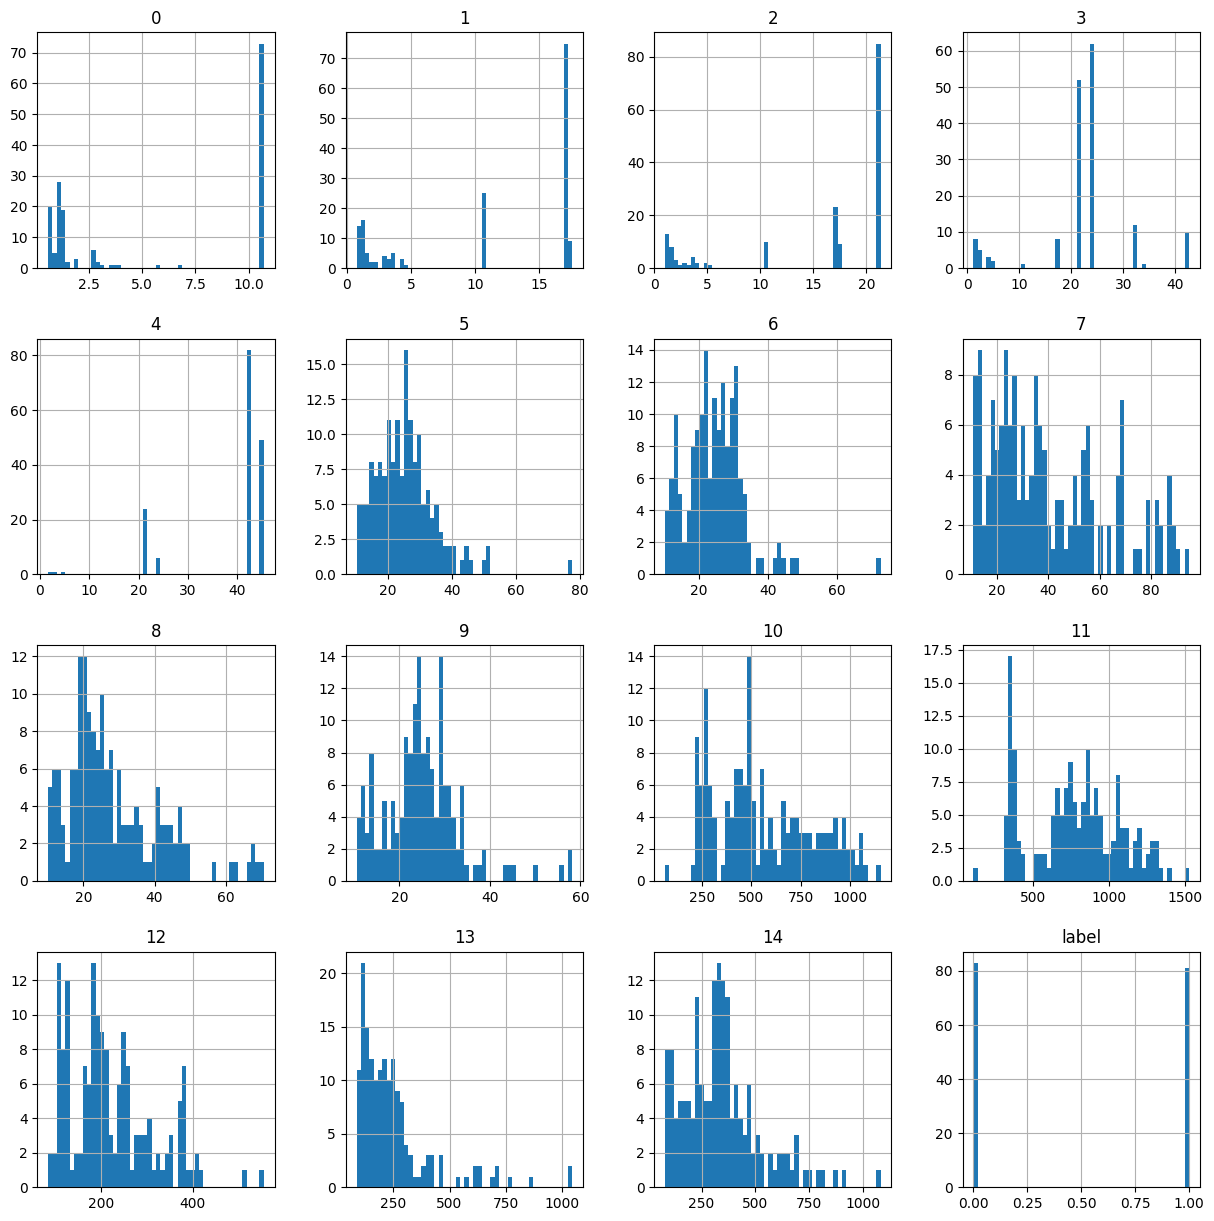

In [290]:
all_df[:-1].hist(bins=50, figsize=(15,15))
plt.show()


### Feature Scaling

In [291]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


[Text(0, 0, 'Gamma'),
 Text(1, 0, 'Alpha'),
 Text(2, 0, 'Beta'),
 Text(3, 0, 'Theta'),
 Text(4, 0, 'Delta')]

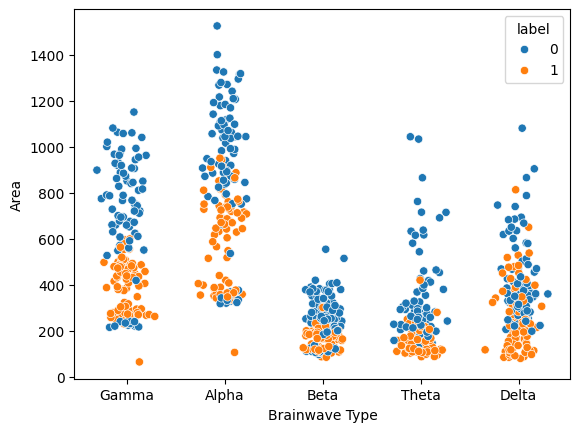

In [297]:
d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() for i in range(len(all_df))], y=10, hue='label', legend=False)
sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + 1 for i in range(len(all_df))], y=11, hue='label', legend=False)
sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + 2  for i in range(len(all_df))], y=12, hue='label', legend=False)
sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + 3  for i in range(len(all_df))], y=13, hue='label', legend=False)
sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + 4  for i in range(len(all_df))], y=14, hue='label')

d.set_ylabel('Area')
d.set_xlabel('Brainwave Type')
d.set_xticks([0,1,2,3,4])
d.set_xticklabels(['Gamma', 'Alpha', 'Beta', 'Theta', 'Delta'])

### Principal Component Analysis (PCA)

In [222]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X)
Z=pca.transform(X)

loadings = pd.DataFrame(
    pca.components_,
    columns=all_df.columns[:-1],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings)

            0         1         2         3         4         5         6  \
PC1 -0.000327  0.000479  0.000427  0.000577  0.004047  0.007555  0.006254   
PC2 -0.012194 -0.022039 -0.025290 -0.026426 -0.028550  0.014509  0.013220   

            7         8         9        10        11        12        13  \
PC1  0.004908  0.015117  0.009349  0.191762  0.629275  0.261088  0.208477   
PC2 -0.042245  0.008381  0.009557  0.044661 -0.237081  0.393409  0.859113   

           14  
PC1  0.674654  
PC2 -0.209363  


## Building Machine Learning Models

### Classification: Support Vector Machine (SVM)

In [242]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'rbf', random_state = 0) ## try differernals and remove the random_state maybe
classifier.fit(X_train, y_train)

SVC(random_state=0)

### SVM: Confusion Matrix

In [243]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(len(X_train))
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")

132
[[14  0]
 [ 2 17]]
Your Model Accuracy is= 93.93939393939394 %


### SVM: Prediction a new Result

### Neural Network (ANN) Model

In [240]:
eegModel = tf.keras.models.Sequential()
eegModel.add(tf.keras.layers.Dense(13,activation='relu'))
eegModel.add(tf.keras.layers.Dense(units=7, activation='relu'))
eegModel.add(tf.keras.layers.Dense(2,activation='softmax'))

eegModel.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
eegModel.fit(X_train, y_train, batch_size = 8, epochs = 20)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3931 - loss: 0.9807
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4681 - loss: 0.7251
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5103 - loss: 0.6380
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7093 - loss: 0.5722
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.5303
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8832 - loss: 0.5008
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8821 - loss: 0.4585
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8369 - loss: 0.4897
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8602 - loss: 0.4641
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.4331
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8952 - loss: 0.4329
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - lo

In [241]:
y_pred = eegModel.predict(X_test)
eegModel.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8775 - loss: 0.3943


[0.390256404876709, 0.8787878751754761]